<a href="https://colab.research.google.com/github/Mai-CS/Enhanced-Deep-Convolutional-Forest/blob/main/enhannced_dcf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Imports***

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, LSTM, GlobalMaxPooling1D, Dense

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from collections import Counter

Mounted at /content/drive


# ***Utils***

## Dataset loading

In [2]:
def load_data(file_name):
    df = pd.read_csv(file_name, encoding="ISO-8859-1"
    )
    df = df.dropna(subset=["ProcessedMessage"], axis=0)
    #   df = df.drop_duplicates(subset=['ProcessedMessage'])
    df.info()

    return df.reset_index(drop=True)

## Get maximum input length

In [3]:
def get_max_input_length(docs):
    max_input_length = 1
    for document in docs:
        words = text_to_word_sequence(document)
        document_length = len(words)
        if document_length > max_input_length:
            max_input_length = document_length

    return max_input_length

## Balance data

In [4]:
def balance_data(X_train, y_train, input_type="numerical"):
    """Oversampling the dataset using SMOTE"""

    # Summarize class distribution
    counter = Counter(y_train)
    print("Before SMOTE: ", counter)

    if input_type == "text":
        # Calculate TF-IDF
        vectorizer = TfidfVectorizer()
        X_train = vectorizer.fit_transform(X_train)

    # Oversampling
    smote_model = SMOTE()
    X_train, y_train = smote_model.fit_resample(X_train, y_train)

    # Summarize the new class distribution
    counter = Counter(y_train)
    print("After SMOTE: ", counter)

    if input_type == "text":
        X_train = vectorizer.inverse_transform(X_train)
        for i in range(0, len(X_train)):
            X_train[i] = " ".join(reversed(X_train[i]))

    return X_train, y_train

## GloVe

In [5]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2024-11-17 21:06:04--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-11-17 21:06:04--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-11-17 21:06:04--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [6]:
def create_embedding_matrix(tokenizer, embedding_dim):
    file_name = ""
    embeddings_index = {}
    if embedding_dim == 50:
        file_name = "glove.6B.50d.txt"
    elif embedding_dim == 100:
        file_name = "glove.6B.100d.txt"

    f = open("/content/" + file_name)
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs
    f.close()

    print("Found %s word vectors." % len(embeddings_index))

    embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

## Text encoding/padding

In [7]:
def encode_text(docs_X_train, docs_X_test):
    # Prepare tokenizer
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(docs_X_train)

    # Integer encode the documents
    encoded_docs_train = tokenizer.texts_to_sequences(docs_X_train)
    encoded_docs_test = tokenizer.texts_to_sequences(docs_X_test)

    # Pad documents to a max length of words
    padded_docs_train = pad_sequences(
        encoded_docs_train,
        maxlen=max_sequence_length,
        padding="post",
        truncating="post",
    )
    padded_docs_test = pad_sequences(
        encoded_docs_test, maxlen=max_sequence_length, padding="post", truncating="post"
    )

    return padded_docs_train, padded_docs_test, tokenizer

# ***DCF***

## Building DCF

In [8]:
import numpy as np
from sklearn import metrics
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.models import Model
import time
# Import your custom functions if they are in separate modules
# from your_module import balance_data, DCF_classify, evaluate_model, roc

def DCF_model(
    X_train,
    X_test,
    y_train,
    y_test,
    params,
    class_weights,
    vocab_size,
    max_sequence_length,
    embedding_matrix,
    embedding_dim,
):
    """Build DCF layers (auto-complexity)"""

    filters = params["filters"]
    kernel_size = params["kernel_size"]
    epochs = params["epochs"]

    # Calculate time of execution
    start_time = time.time()

    max_num_iterations = 10
    count = 0
    accuracy = 0  # Initialize accuracy
    best_pred = None
    best_proba = None
    best_level = 0  # Initialize best level

    for i in range(1, max_num_iterations, 1):
        pooling_layer_name = "pool_layer" + str(i)
        if i == 1:
            input_layer = Input(shape=(max_sequence_length,))
            embedding_layer = Embedding(
                vocab_size,
                embedding_dim,
                input_length=max_sequence_length,
                weights=[embedding_matrix],
                trainable=True,
                mask_zero=True,
            )(input_layer)
            conv_layer = Conv1D(filters=filters, kernel_size=kernel_size, activation="relu")(embedding_layer)
            pooling_layer = GlobalMaxPooling1D(name=pooling_layer_name)(conv_layer)
            output_layer = Dense(2, activation="softmax")(pooling_layer)

            model = Model(inputs=input_layer, outputs=output_layer)

        elif i > 1:
            X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
            X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

            input_layer = Input(shape=(X_train.shape[1], 1))
            conv_layer = Conv1D(
                filters=filters,
                kernel_size=kernel_size,
                activation="relu",
            )(input_layer)
            pooling_layer = GlobalMaxPooling1D(name=pooling_layer_name)(conv_layer)
            output_layer = Dense(2, activation="softmax")(pooling_layer)

            model = Model(inputs=input_layer, outputs=output_layer)

        model.compile(
            loss="sparse_categorical_crossentropy",
            optimizer="adam",
            metrics=["accuracy"],
        )
        model.fit(
            X_train, y_train, class_weight=class_weights, epochs=epochs, verbose=0
        )

        feature_maps_model = Model(
            inputs=model.input, outputs=model.get_layer(pooling_layer_name).output
        )
        X_train = feature_maps_model.predict(X_train)
        X_test = feature_maps_model.predict(X_test)
        print("Train Output shape: " + str(X_train.shape))
        print("Test Output shape: " + str(X_test.shape))

        # Summarize the model
        print()
        print(model.summary())

        if i == 1:
            X_train, y_train = balance_data(X_train, y_train)

            # Classify using Random Forest and Extremely Randomized Trees
            probs_train, probs_test, y_pred, y_proba = DCF_classify(
                X_train, X_test, y_train, y_test, class_weights
            )

            accuracy = metrics.accuracy_score(y_test, y_pred)
            print("Accuracy of level #1 = ", accuracy)
            best_pred = y_pred
            best_proba = y_proba
            best_level = i

            print(metrics.classification_report(y_test, y_pred, digits=4))

        elif i > 1:
            X_train_with_probs = np.concatenate((X_train, probs_train), axis=1)
            X_test_with_probs = np.concatenate((X_test, probs_test), axis=1)

            probs_train, probs_test, y_pred, y_proba = DCF_classify(
                X_train_with_probs, X_test_with_probs, y_train, y_test, class_weights
            )

            new_accuracy = metrics.accuracy_score(y_test, y_pred)

            print(metrics.classification_report(y_test, y_pred, digits=4))

            print("Accuracy of level #", i, " = ", new_accuracy)
            if accuracy < new_accuracy:
                accuracy = new_accuracy
                best_pred = y_pred
                best_proba = y_proba
                best_level = i
                count = 0
            else:
                count += 1

            if count >= 1:
                print("Total number of levels = ", i)
                break

    end_time = time.time()
    print("\nRuntime of DCF = ", end_time - start_time)
    print("\nDCF's Final accuracy = ", accuracy, " at level #", best_level, "\n")

    # Calculate/Plot classification metrics
    evaluate_model(y_test, best_pred)
    fpr, tpr, auc = roc(y_test, best_proba)

    return fpr, tpr, auc


## Classification

In [9]:
def DCF_classify(X_train, X_test, y_train, y_test, class_weights):
    """Build DCF's base classifiers (RandomForestClassifier and ExtraTreesClassifier)"""

    classifier1 = RandomForestClassifier(
        n_estimators=100, criterion="gini", class_weight=class_weights, random_state=0
    )
    classifier2 = RandomForestClassifier(
        n_estimators=100,
        criterion="entropy",
        class_weight=class_weights,
        random_state=0,
    )
    classifier3 = ExtraTreesClassifier(
        n_estimators=100, criterion="gini", class_weight=class_weights, random_state=0
    )
    classifier4 = ExtraTreesClassifier(
        n_estimators=100,
        criterion="entropy",
        class_weight=class_weights,
        random_state=0,
    )

    # Classifier 1
    classifier1.fit(X_train, y_train)
    probs_train1 = classifier1.predict_proba(X_train)
    probs_test1 = classifier1.predict_proba(X_test)

    # Classifier 2
    classifier2.fit(X_train, y_train)
    probs_train2 = classifier2.predict_proba(X_train)
    probs_test2 = classifier2.predict_proba(X_test)

    # Classifier 3
    classifier3.fit(X_train, y_train)
    probs_train3 = classifier3.predict_proba(X_train)
    probs_test3 = classifier3.predict_proba(X_test)

    # Classifier 4
    classifier4.fit(X_train, y_train)
    probs_train4 = classifier4.predict_proba(X_train)
    probs_test4 = classifier4.predict_proba(X_test)

    probs_train = np.concatenate(
        (probs_train1, probs_train2, probs_train3, probs_train4), axis=1
    )
    probs_test = np.concatenate(
        (probs_test1, probs_test2, probs_test3, probs_test4), axis=1
    )

    y_pred = []
    y_proba = []
    for i in range(0, len(X_test)):
        avg_ham = (
            probs_test1[i][0]
            + probs_test2[i][0]
            + probs_test3[i][0]
            + probs_test4[i][0]
        ) / 4
        avg_spam = (
            probs_test1[i][1]
            + probs_test2[i][1]
            + probs_test3[i][1]
            + probs_test4[i][1]
        ) / 4
        if avg_ham > avg_spam:
            # ham
            y_pred.append(0)
        else:
            # spam
            y_pred.append(1)

        max_spam = max(
            [probs_test1[i][1], probs_test2[i][1], probs_test3[i][1], probs_test4[i][1]]
        )
        y_proba.append(max_spam)

    return probs_train, probs_test, y_pred, y_proba

## Evaluating

In [10]:
def evaluate_model(y_test, y_pred):
    """Plot confusion matrix and print classification report"""

    target_names = ["Ham", "Spam"]

    # Plot normalized confusion matrix
    plot_confusion_matrix(y_test, y_pred)

    print(
        metrics.classification_report(
            y_test, y_pred, target_names=target_names, digits=4
        )
    )


def plot_confusion_matrix(y_test, y_pred):
    """Calculate and print the confusion matrix"""

    print(metrics.confusion_matrix(y_test, y_pred))


def roc(y_test, y_proba):
    """Calculate ROC curve"""

    fpr, tpr, _ = metrics.roc_curve(y_test, y_proba)
    auc = metrics.roc_auc_score(y_test, y_proba)
    return fpr, tpr, auc

# ***Deep Learning Algorithms***

## CNN

In [11]:
def cnn_model_v1(
    X_train,
    X_test,
    y_train,
    y_test,
    params,
    class_weights,
    vocab_size,
    max_sequence_length,
    embedding_matrix,
    embedding_dim,
):
    filters = params["filters"]
    kernel_size = params["kernel_size"]
    epochs = params["epochs"]

    start_time = time.time()

    model = Sequential()
    model.add(
        Embedding(
            vocab_size,
            embedding_dim,
            input_length=max_sequence_length,
            weights=[embedding_matrix],
            trainable=True,
            mask_zero=True,
        )
    )
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation="relu"))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(2, activation="softmax"))

    model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    model.fit(X_train, y_train, class_weight=class_weights, epochs=epochs, verbose=0)

    model.evaluate(X_test, y_test)
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_proba = model.predict(X_test)[::, 1]

    end_time = time.time()
    print("\nRuntime of 1-CNN = ", end_time - start_time)

    print("Classification metrics of 1-layer CNN")
    print(metrics.classification_report(y_test, y_pred, digits=4))

    fpr, tpr, auc = roc(y_test, y_proba)

    return fpr, tpr, auc

In [12]:
def cnn_model_v2(
    X_train,
    X_test,
    y_train,
    y_test,
    params,
    class_weights,
    vocab_size,
    max_sequence_length,
    embedding_matrix,
    embedding_dim,
):
    filters = params["filters"]
    kernel_size = params["kernel_size"]
    epochs = params["epochs"]

    start_time = time.time()

    model = Sequential()
    model.add(
        Embedding(
            vocab_size,
            embedding_dim,
            input_length=max_sequence_length,
            weights=[embedding_matrix],
            trainable=True,
            mask_zero=True,
        )
    )
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation="relu"))
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation="relu"))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(2, activation="softmax"))

    model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    model.fit(X_train, y_train, class_weight=class_weights, epochs=epochs, verbose=0)

    model.evaluate(X_test, y_test)
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_proba = model.predict(X_test)[::, 1]

    end_time = time.time()
    print("\nRuntime of 2-CNN = ", end_time - start_time)

    print("Classification metrics of 2-layer CNN")
    print(metrics.classification_report(y_test, y_pred, digits=4))

    fpr, tpr, auc = roc(y_test, y_proba)

    return fpr, tpr, auc

In [13]:
def cnn_model_v3(
    X_train,
    X_test,
    y_train,
    y_test,
    params,
    class_weights,
    vocab_size,
    max_sequence_length,
    embedding_matrix,
    embedding_dim,
):
    filters = params["filters"]
    kernel_size = params["kernel_size"]
    epochs = params["epochs"]

    start_time = time.time()

    model = Sequential()
    model.add(
        Embedding(
            vocab_size,
            embedding_dim,
            input_length=max_sequence_length,
            weights=[embedding_matrix],
            trainable=True,
            mask_zero=True,
        )
    )
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation="relu"))
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation="relu"))
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation="relu"))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(2, activation="softmax"))

    model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    model.fit(X_train, y_train, class_weight=class_weights, epochs=epochs, verbose=0)

    model.evaluate(X_test, y_test)
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_proba = model.predict(X_test)[::, 1]

    end_time = time.time()
    print("\nRuntime of 3-CNN = ", end_time - start_time)

    print("Classification metrics of 3-layer CNN")
    print(metrics.classification_report(y_test, y_pred, digits=4))

    fpr, tpr, auc = roc(y_test, y_proba)

    return fpr, tpr, auc

## LSTM

In [14]:
def lstm_model(
    X_train,
    X_test,
    y_train,
    y_test,
    params,
    class_weights,
    vocab_size,
    max_sequence_length,
    embedding_matrix,
    embedding_dim,
):
    units = params["units"]
    epochs = params["epochs"]

    start_time = time.time()

    model = Sequential()
    model.add(
        Embedding(
            vocab_size,
            embedding_dim,
            input_length=max_sequence_length,
            weights=[embedding_matrix],
            trainable=True,
            mask_zero=True,
        )
    )
    model.add(LSTM(units=units, activation="relu"))
    model.add(Dense(2, activation="softmax"))

    model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    model.fit(X_train, y_train, class_weight=class_weights, epochs=epochs, verbose=0)

    model.evaluate(X_test, y_test)
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_proba = model.predict(X_test)[::, 1]

    end_time = time.time()
    print("\nRuntime of LSTM = ", end_time - start_time)

    print("Classification metrics of LSTM")
    print(metrics.classification_report(y_test, y_pred, digits=4))

    fpr, tpr, auc = roc(y_test, y_proba)

    return fpr, tpr, auc

## All DL models (CNN, LSTM)

In [15]:
import pandas as pd

def DL_models(
    DCF_fpr,
    DCF_tpr,
    DCF_auc,
    X_train,
    X_test,
    y_train,
    y_test,
    params,
    class_weights,
    vocab_size,
    max_sequence_length,
    embedding_matrix,
    embedding_dim,
):
    """Compare DCF with deep learning techniques"""

    result_table = pd.DataFrame(columns=["classifiers", "fpr", "tpr", "auc"])

    print("\n*******************************1-CNN*******************************\n")
    fpr, tpr, auc = cnn_model_v1(
        X_train,
        X_test,
        y_train,
        y_test,
        params=params,
        class_weights=class_weights,
        vocab_size=vocab_size,
        max_sequence_length=max_sequence_length,
        embedding_matrix=embedding_matrix,
        embedding_dim=embedding_dim,
    )
    new_row = pd.DataFrame([{"classifiers": "1-CNN", "fpr": fpr, "tpr": tpr, "auc": auc}])
    result_table = pd.concat([result_table, new_row], ignore_index=True)

    print("\n*******************************2-CNN*******************************\n")
    fpr, tpr, auc = cnn_model_v2(
        X_train,
        X_test,
        y_train,
        y_test,
        params=params,
        class_weights=class_weights,
        vocab_size=vocab_size,
        max_sequence_length=max_sequence_length,
        embedding_matrix=embedding_matrix,
        embedding_dim=embedding_dim,
    )
    new_row = pd.DataFrame([{"classifiers": "2-CNN", "fpr": fpr, "tpr": tpr, "auc": auc}])
    result_table = pd.concat([result_table, new_row], ignore_index=True)

    print("\n*******************************3-CNN*******************************\n")
    fpr, tpr, auc = cnn_model_v3(
        X_train,
        X_test,
        y_train,
        y_test,
        params=params,
        class_weights=class_weights,
        vocab_size=vocab_size,
        max_sequence_length=max_sequence_length,
        embedding_matrix=embedding_matrix,
        embedding_dim=embedding_dim,
    )
    new_row = pd.DataFrame([{"classifiers": "3-CNN", "fpr": fpr, "tpr": tpr, "auc": auc}])
    result_table = pd.concat([result_table, new_row], ignore_index=True)

    print("\n*******************************LSTM*******************************\n")
    fpr, tpr, auc = lstm_model(
        X_train,
        X_test,
        y_train,
        y_test,
        params=params,
        class_weights=class_weights,
        vocab_size=vocab_size,
        max_sequence_length=max_sequence_length,
        embedding_matrix=embedding_matrix,
        embedding_dim=embedding_dim,
    )
    new_row = pd.DataFrame([{"classifiers": "LSTM", "fpr": fpr, "tpr": tpr, "auc": auc}])
    result_table = pd.concat([result_table, new_row], ignore_index=True)

    # Adding DCF metrics to result_table
    new_row = pd.DataFrame([{"classifiers": "DCF", "fpr": DCF_fpr, "tpr": DCF_tpr, "auc": DCF_auc}])
    result_table = pd.concat([result_table, new_row], ignore_index=True)

    # Set name of the classifiers as index labels
    result_table.set_index("classifiers", inplace=True)

    # Plot multiple ROC-Curve
    plot_ROC_all("ROC for DL models", result_table)


# ***Machine Learning Algorithms***

## All ML models (SVM, NB, KNN, RF)

In [16]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

def ML_models(
    DCF_fpr,
    DCF_tpr,
    DCF_auc,
    features_train,
    features_test,
    y_train,
    y_test,
    class_weights,
):
    """Compare DCF with machine learning algorithms"""

    classifiers = [
        SVC(random_state=0, kernel="rbf", probability=True),
        GaussianNB(),
        KNeighborsClassifier(),
        RandomForestClassifier(
            n_estimators=100, class_weight=class_weights, random_state=0
        ),
    ]

    result_table = pd.DataFrame(columns=["classifiers", "fpr", "tpr", "auc"])

    # Train the models and record the results
    i = 0
    for cls in classifiers:
        i += 1
        # Assign classifier names based on iteration
        classifier_name = "SVM"
        if i == 2:
            classifier_name = "NB"
        elif i == 3:
            classifier_name = "KNN"
        elif i == 4:
            classifier_name = "RF"

        model = cls.fit(features_train, y_train)
        y_pred = model.predict(features_test)
        y_proba = model.predict_proba(features_test)[::, 1]

        fpr, tpr, _ = metrics.roc_curve(y_test, y_proba)
        auc = metrics.roc_auc_score(y_test, y_proba)

        # Create a new DataFrame for the current result
        new_row = pd.DataFrame([{
            "classifiers": classifier_name,
            "fpr": fpr,
            "tpr": tpr,
            "auc": auc
        }])

        # Concatenate the new row to the result_table
        result_table = pd.concat([result_table, new_row], ignore_index=True)

        print("Classification report of", cls.__class__.__name__)
        print(metrics.classification_report(y_test, y_pred, digits=4))

    # Adding DCF metrics to result_table
    new_row = pd.DataFrame([{
        "classifiers": "DCF",
        "fpr": DCF_fpr,
        "tpr": DCF_tpr,
        "auc": DCF_auc
    }])
    result_table = pd.concat([result_table, new_row], ignore_index=True)

    # Set name of the classifiers as index labels
    result_table.set_index("classifiers", inplace=True)

    # Plot multiple ROC-Curve
    plot_ROC_all("ROC for ML models", result_table)


# ***Plot ROC for All Models***

In [17]:
def plot_ROC_all(plot_name, result_table):
    """Plot multiple ROC-Curve"""

    fig = plt.figure(figsize=(8, 6))

    for i in result_table.index:
        plt.plot(
            result_table.loc[i]["fpr"],
            result_table.loc[i]["tpr"],
            label="{}, AUC={:.3f}".format(i, result_table.loc[i]["auc"]),
        )

    plt.plot([0, 1], [0, 1], color="orange", linestyle="--")

    plt.xticks(np.arange(0.0, 1.1, step=0.1))
    plt.xlabel("False Positive Rate", fontsize=15)

    plt.yticks(np.arange(0.0, 1.1, step=0.1))
    plt.ylabel("True Positive Rate", fontsize=15)

    plt.legend(prop={"size": 13}, loc="lower right")

    plt.show()
    fig.savefig("/content/" + plot_name + ".pdf")

# ***Main***

<class 'pandas.core.frame.DataFrame'>
Index: 5563 entries, 0 to 5570
Data columns (total 45 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Label                    5563 non-null   int64  
 1   Message                  5563 non-null   object 
 2   ProcessedMessage         5563 non-null   object 
 3   characters_count         5563 non-null   int64  
 4   words_count              5563 non-null   int64  
 5   readability              5563 non-null   float64
 6   misspelled_count         5563 non-null   int64  
 7   emails_count             5563 non-null   int64  
 8   phones_count             5563 non-null   int64  
 9   is_currency_found        5563 non-null   int64  
 10  call                     5563 non-null   int64  
 11  Ã¥Â£                     5563 non-null   int64  
 12  free                     5563 non-null   int64  
 13  txt                      5563 non-null   int64  
 14  text                     5563

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Train Output shape: (4450, 64)
Test Output shape: (1113, 64)



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 80)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 80, 100)             │         691,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 79, 64)              │          12,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_layer1 (GlobalMaxPooling1D)     │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,113,784 (8.06 MB)

 Trainable params: 704,594 (2.69 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,409,190 (5.38 MB)

None
Before SMOTE:  Counter({0: 3883, 1: 567})
After SMOTE:  Counter({0: 3883, 1: 3883})
Accuracy of level #1 =  0.9838274932614556
              precision    recall  f1-score   support

           0     0.9821    0.9989    0.9904       933
           1     0.9939    0.9056    0.9477       180

    accuracy                         0.9838      1113
   macro avg     0.9880    0.9522    0.9691      1113
weighted avg     0.9840    0.9838    0.9835      1113

243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Train Output shape: (7766, 64)
Test Output shape: (1113, 64)



Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 63, 64)              │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_layer2 (GlobalMaxPooling1D)     │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 968 (3.79 KB)

 Trainable params: 322 (1.26 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 646 (2.53 KB)

None
              precision    recall  f1-score   support

           0     0.9821    0.9989    0.9904       933
           1     0.9939    0.9056    0.9477       180

    accuracy                         0.9838      1113
   macro avg     0.9880    0.9522    0.9691      1113
weighted avg     0.9840    0.9838    0.9835      1113

Accuracy of level # 2  =  0.9838274932614556
Total number of levels =  2

Runtime of DCF =  76.66135787963867

DCF's Final accuracy =  0.9838274932614556  at level # 1 

[[932   1]
 [ 17 163]]
              precision    recall  f1-score   support

         Ham     0.9821    0.9989    0.9904       933
        Spam     0.9939    0.9056    0.9477       180

    accuracy                         0.9838      1113
   macro avg     0.9880    0.9522    0.9691      1113
weighted avg     0.9840    0.9838    0.9835      1113


**************************Run DL classifiers*************************

Before SMOTE:  Counter({0: 3883, 1: 567})
After SMOTE:  Counter({0: 3883, 1:

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'conv1d_2' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9756 - loss: 0.0732
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Runtime of 1-CNN =  56.5993869304657
Classification metrics of 1-layer CNN
              precision    recall  f1-score   support

           0     0.9830    0.9893    0.9861       933
           1     0.9425    0.9111    0.9266       180

    accuracy                         0.9766      1113
   macro avg     0.9627    0.9502    0.9563      1113
weighted avg     0.9764    0.9766    0.9765      1113


*******************************2-CNN*******************************



<ipython-input-15-55b1b18c7aad>:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_table = pd.concat([result_table, new_row], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'conv1d_3' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9769 - loss: 0.0848
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Runtime of 2-CNN =  76.49092149734497
Classification metrics of 2-layer CNN
              precision    recall  f1-score   support

           0     0.9840    0.9882    0.9861       933
           1     0.9375    0.9167    0.9270       180

    accuracy                         0.9766      1113
   macro avg     0.9607    0.9524    0.9565      1113
weighted avg     0.9765    0.9766    0.9765      1113


*******************************3-CNN*******************************



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'conv1d_5' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9682 - loss: 0.1805
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Runtime of 3-CNN =  73.72231125831604
Classification metrics of 3-layer CNN
              precision    recall  f1-score   support

           0     0.9776    0.9829    0.9802       933
           1     0.9086    0.8833    0.8958       180

    accuracy                         0.9668      1113
   macro avg     0.9431    0.9331    0.9380      1113
weighted avg     0.9664    0.9668    0.9666      1113


*******************************LSTM*******************************



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9772 - loss: 0.5606
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step

Runtime of LSTM =  271.6192123889923
Classification metrics of LSTM
              precision    recall  f1-score   support

           0     0.9881    0.9807    0.9844       933
           1     0.9037    0.9389    0.9210       180

    accuracy                         0.9739      1113
   macro avg     0.9459    0.9598    0.9527      1113
weighted avg     0.9745    0.9739    0.9741      1113



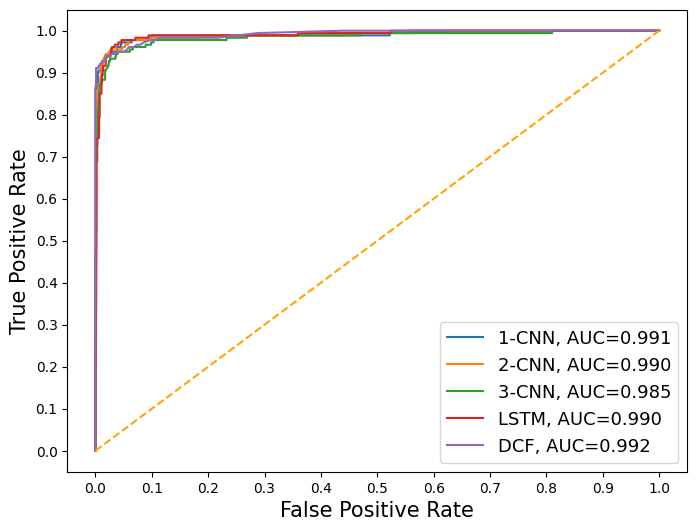


**************************Run ML classifiers*************************

Before SMOTE:  Counter({0: 3883, 1: 567})
After SMOTE:  Counter({0: 3883, 1: 3883})


<ipython-input-16-4f555436b20c>:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_table = pd.concat([result_table, new_row], ignore_index=True)


Classification report of SVC
              precision    recall  f1-score   support

           0     0.9789    0.8446    0.9068       933
           1     0.5292    0.9056    0.6680       180

    accuracy                         0.8544      1113
   macro avg     0.7541    0.8751    0.7874      1113
weighted avg     0.9062    0.8544    0.8682      1113

Classification report of GaussianNB
              precision    recall  f1-score   support

           0     0.9611    0.9796    0.9703       933
           1     0.8827    0.7944    0.8363       180

    accuracy                         0.9497      1113
   macro avg     0.9219    0.8870    0.9033      1113
weighted avg     0.9484    0.9497    0.9486      1113

Classification report of KNeighborsClassifier
              precision    recall  f1-score   support

           0     0.9624    0.9057    0.9332       933
           1     0.6255    0.8167    0.7084       180

    accuracy                         0.8913      1113
   macro avg     

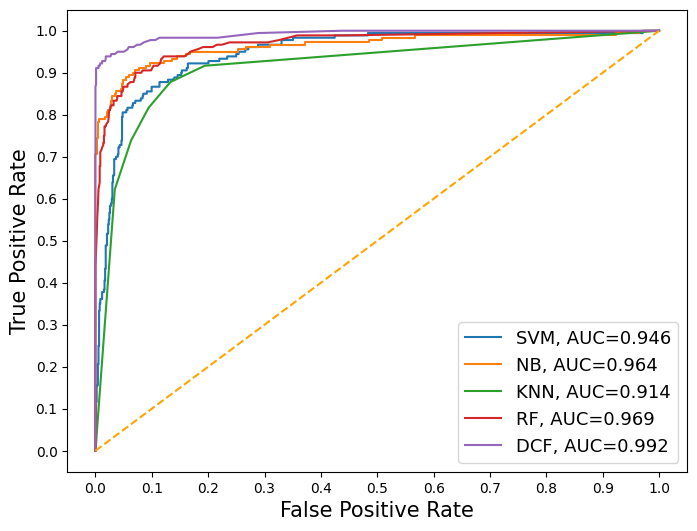

In [19]:
df = load_data("/content/drive/MyDrive/PROJ795data/processed_spam.csv")

data = df.drop(["Label"], axis=1)
targets = df["Label"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    data, targets, test_size=0.20, random_state=0
)

docs_X_train = X_train["ProcessedMessage"]
docs_X_test = X_test["ProcessedMessage"]
max_sequence_length = get_max_input_length(docs_X_train)
padded_docs_train, padded_docs_test, tokenizer = encode_text(docs_X_train, docs_X_test)
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
# Retrieve GloVe word embeddings
embedding_matrix = create_embedding_matrix(tokenizer, embedding_dim)

params = {"filters": 64, "kernel_size": 2, "units": 64, "epochs": 10}

class_weights = None

print("\n*******************************Run DCF*******************************\n")
DCF_fpr, DCF_tpr, DCF_auc = DCF_model(
    padded_docs_train,
    padded_docs_test,
    y_train,
    y_test,
    params=params,
    class_weights=class_weights,
    vocab_size=vocab_size,
    max_sequence_length=max_sequence_length,
    embedding_matrix=embedding_matrix,
    embedding_dim=embedding_dim,
)

print("\n**************************Run DL classifiers*************************\n")
docs_X_train = X_train["ProcessedMessage"]
docs_X_test = X_test["ProcessedMessage"]
docs_X_train, docs_y_train = balance_data(docs_X_train, y_train, input_type="text")

max_sequence_length = get_max_input_length(docs_X_train)
padded_docs_train, padded_docs_test, tokenizer = encode_text(docs_X_train, docs_X_test)
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
# Retrieve GloVe word embeddings
embedding_matrix = create_embedding_matrix(tokenizer, embedding_dim)

DL_models(
    DCF_fpr,
    DCF_tpr,
    DCF_auc,
    padded_docs_train,
    padded_docs_test,
    docs_y_train,
    y_test,
    params=params,
    class_weights=class_weights,
    vocab_size=vocab_size,
    max_sequence_length=max_sequence_length,
    embedding_matrix=embedding_matrix,
    embedding_dim=embedding_dim,
)

print("\n**************************Run ML classifiers*************************\n")
feature_names = [
    "characters_count",
    "words_count",
    "readability",
    "misspelled_count",
    "emails_count",
    "phones_count",
    "is_currency_found",
    "ip_count",
    "urls_count",
    "has_blacklist_url",
]
features_train = X_train[feature_names]
features_test = X_test[feature_names]

features_train, y_train = balance_data(features_train, y_train)

ML_models(
    DCF_fpr,
    DCF_tpr,
    DCF_auc,
    features_train,
    features_test,
    y_train,
    y_test,
    class_weights=class_weights,
)

# Transferability

In [21]:
def load_data(file_name):
    df = pd.read_csv(file_name, encoding="ISO-8859-1"
    )
    df = df.dropna(subset=["text"], axis=0)
    #   df = df.drop_duplicates(subset=['ProcessedMessage'])
    df.info()

    return df.reset_index(drop=True)

In [22]:
df = load_data("/content/drive/MyDrive/PROJ795data/mail_dataset.csv")

data = df.drop(["label_num"], axis=1)
targets = df["label_num"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    data, targets, test_size=0.20, random_state=0
)

docs_X_train = X_train["text"]
docs_X_test = X_test["text"]
max_sequence_length = get_max_input_length(docs_X_train)
padded_docs_train, padded_docs_test, tokenizer = encode_text(docs_X_train, docs_X_test)
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
# Retrieve GloVe word embeddings
embedding_matrix = create_embedding_matrix(tokenizer, embedding_dim)

params = {"filters": 64, "kernel_size": 2, "units": 64, "epochs": 10}

class_weights = None

print("\n*******************************Run DCF*******************************\n")
DCF_fpr, DCF_tpr, DCF_auc = DCF_model(
    padded_docs_train,
    padded_docs_test,
    y_train,
    y_test,
    params=params,
    class_weights=class_weights,
    vocab_size=vocab_size,
    max_sequence_length=max_sequence_length,
    embedding_matrix=embedding_matrix,
    embedding_dim=embedding_dim,
)

print("\n**************************Run DL classifiers*************************\n")
docs_X_train = X_train["text"]
docs_X_test = X_test["text"]
docs_X_train, docs_y_train = balance_data(docs_X_train, y_train, input_type="text")

max_sequence_length = get_max_input_length(docs_X_train)
padded_docs_train, padded_docs_test, tokenizer = encode_text(docs_X_train, docs_X_test)
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
# Retrieve GloVe word embeddings
embedding_matrix = create_embedding_matrix(tokenizer, embedding_dim)

DL_models(
    DCF_fpr,
    DCF_tpr,
    DCF_auc,
    padded_docs_train,
    padded_docs_test,
    docs_y_train,
    y_test,
    params=params,
    class_weights=class_weights,
    vocab_size=vocab_size,
    max_sequence_length=max_sequence_length,
    embedding_matrix=embedding_matrix,
    embedding_dim=embedding_dim,
)

# print("\n**************************Run ML classifiers*************************\n")
# feature_names = [
#     "characters_count",
#     "words_count",
#     "readability",
#     "misspelled_count",
#     "emails_count",
#     "phones_count",
#     "is_currency_found",
#     "ip_count",
#     "urls_count",
#     "has_blacklist_url",
# ]
# features_train = X_train[feature_names]
# features_test = X_test[feature_names]

# features_train, y_train = balance_data(features_train, y_train)

# ML_models(
#     DCF_fpr,
#     DCF_tpr,
#     DCF_auc,
#     features_train,
#     features_test,
#     y_train,
#     y_test,
#     class_weights=class_weights,
# )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB
Found 400000 word vectors.

*******************************Run DCF*******************************



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'conv1d_8' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


130/130 ━━━━━━━━━━━━━━━━━━━━ 15s 112ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step
Train Output shape: (4136, 64)
Test Output shape: (1035, 64)



Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 2619)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_5 (Embedding)              │ (None, 2619, 100)           │       5,003,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 2618, 64)            │          12,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_layer1 (GlobalMaxPooling1D)     │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,050,384 (57.41 MB)

 Trainable params: 5,016,794 (19.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,033,590 (38.28 MB)

None
Before SMOTE:  Counter({0: 2940, 1: 1196})
After SMOTE:  Counter({0: 2940, 1: 2940})
Accuracy of level #1 =  0.978743961352657
              precision    recall  f1-score   support

           0     0.9850    0.9850    0.9850       732
           1     0.9637    0.9637    0.9637       303

    accuracy                         0.9787      1035
   macro avg     0.9743    0.9743    0.9743      1035
weighted avg     0.9787    0.9787    0.9787      1035

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Train Output shape: (5880, 64)
Test Output shape: (1035, 64)



Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 64, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ (None, 63, 64)              │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_layer2 (GlobalMaxPooling1D)     │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 968 (3.79 KB)

 Trainable params: 322 (1.26 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 646 (2.53 KB)

None
              precision    recall  f1-score   support

           0     0.9836    0.9850    0.9843       732
           1     0.9636    0.9604    0.9620       303

    accuracy                         0.9778      1035
   macro avg     0.9736    0.9727    0.9731      1035
weighted avg     0.9778    0.9778    0.9778      1035

Accuracy of level # 2  =  0.9777777777777777
Total number of levels =  2

Runtime of DCF =  732.6698250770569

DCF's Final accuracy =  0.978743961352657  at level # 1 

[[721  11]
 [ 11 292]]
              precision    recall  f1-score   support

         Ham     0.9850    0.9850    0.9850       732
        Spam     0.9637    0.9637    0.9637       303

    accuracy                         0.9787      1035
   macro avg     0.9743    0.9743    0.9743      1035
weighted avg     0.9787    0.9787    0.9787      1035


**************************Run DL classifiers*************************

Before SMOTE:  Counter({0: 2940, 1: 1196})
After SMOTE:  Counter({0: 2940, 1:

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'conv1d_10' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9778 - loss: 0.0778
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step

Runtime of 1-CNN =  749.0598881244659
Classification metrics of 1-layer CNN
              precision    recall  f1-score   support

           0     0.9944    0.9699    0.9820       732
           1     0.9315    0.9868    0.9583       303

    accuracy                         0.9749      1035
   macro avg     0.9629    0.9784    0.9702      1035
weighted avg     0.9760    0.9749    0.9751      1035


*******************************2-CNN*******************************



<ipython-input-15-55b1b18c7aad>:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_table = pd.concat([result_table, new_row], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'conv1d_11' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.9738 - loss: 0.1026
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step

Runtime of 2-CNN =  1073.3563759326935
Classification metrics of 2-layer CNN
              precision    recall  f1-score   support

           0     0.9902    0.9686    0.9793       732
           1     0.9279    0.9769    0.9518       303

    accuracy                         0.9710      1035
   macro avg     0.9591    0.9727    0.9655      1035
weighted avg     0.9720    0.9710    0.9712      1035


*******************************3-CNN*******************************



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'conv1d_13' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step - accuracy: 0.9618 - loss: 0.1421
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step

Runtime of 3-CNN =  1369.1456127166748
Classification metrics of 3-layer CNN
              precision    recall  f1-score   support

           0     0.9753    0.9713    0.9733       732
           1     0.9314    0.9406    0.9360       303

    accuracy                         0.9623      1035
   macro avg     0.9533    0.9560    0.9546      1035
weighted avg     0.9624    0.9623    0.9624      1035


*******************************LSTM*******************************



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 484ms/step - accuracy: 0.7090 - loss: nan
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 590ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 366ms/step

Runtime of LSTM =  5607.010129213333
Classification metrics of LSTM
              precision    recall  f1-score   support

           0     0.7072    1.0000    0.8285       732
           1     0.0000    0.0000    0.0000       303

    accuracy                         0.7072      1035
   macro avg     0.3536    0.5000    0.4143      1035
weighted avg     0.5002    0.7072    0.5860      1035



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ValueError: Input contains NaN.